In [1]:
# Import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import verde as vd
import multiprocessing
from itertools import accumulate

from tqdm import tqdm

import xarray as xr

import time, array, random

from deap import base, creator, tools, algorithms

from CODES.modeling import create_seismic_model,calculate_parameters,calculate_parameters_from_vs
from CODES.dispersion_curves import create_velocity_model_from_profile,create_velocity_model_from_profile_vs,estimate_disp_from_velocity_model

from parameters_py.config import (
					MODEL_NAME,FOLDER_OUTPUT,
                    MIN_THICK_LAYER,MAX_THICK_LAYER,MAX_TOTAL,MAX_LAYERS,LOW_VELS,UP_VELS,
                    MUTPB,CXPB,HOF_NUM,NGEN,POPULATION,N_INV,
                    NUM_PROCESS)

/home/sysop/Programs/anaconda3/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


Reading configuration file: ./config_file.cnf


## Ensure reproducible results by fixing seeds for numpy

In [2]:
np.random.seed(42)  # any integer works
random.seed(42)  # any integer works

# Text based on:

- Gallagher, K., & Sambridge, M. (1994). **Genetic algorithms: a powerful tool for large-scale nonlinear optimization problems**. Comput. Geosci., 20(7–8), 1229–1236.
- Fortin, F. A., Rainville, F. M., Gardner, M., Parizeau, M., and Gagné, C. **DEAP: Evolutionary Algorithms Made Easy**, Journal of Machine Learning Research, pp. 2171-2175, no 13, jul 2012.
- Haskell, N. A. ,1953, **The dispersion of surface waves on multi-layered media**, Bull. Seism. Soc. Am. 43, 17-34.
- Xia, J., Miller, R. D.,  and Park,C. B., 1999, **Estimation of near‐surface shear‐wave velocity by inversion of Rayleigh waves**, GEOPHYSICS 1999 64:3, 691-700.
- Yamanaka, H., and H. Ishida, 1996, **Application of genetic algorithms to an inversion of surface-wave dispersion data**, Bulletin of the Seismological Society of America, 86, 436–444.

# Inversion of Surface-Wave Dispersion Data

Elastic properties of near-surface materials and their effects on seismic-wave propagation are of fundamental interest in groundwater, engineering, and environmental studies (Xia et al, 1999). 

**Rayleigh-wave phase velocity is the function of four parameters (Xia et al, 1999):**
    - S-wave velocity;
    - P-wave velocity;
    - Density; and
    - Layer thickness.

Each parameter contributes to the dispersion curve in a unique way and it can be negated from the inverse procedure if contributions to the dispersion curve from that parameter are relatively small in a certain frequency range. Based on the analysis of Xia et al (1999), the ratio of percentage change in the phase velocities to percentage change in the S-wave velocity, thickness of layer, density, or P-wave velocity is 1.56, 0.64, 0.4, or 0.13, respectively. The S-wave velocity is the dominant parameter inﬂuencing changes in Rayleigh-wave phase velocity.

According to Yamanaka and Ishida (1996):

- Surface-wave dispersion analysis is used to extract a subsurface structural model from records of diverse seismic sources.
- In the process of inversion of a dispersion curve, a structural model is determined by fitting the observed dispersion curves with a theoretical curve.
- A dispersion curve for a surface wave propagating in a horizontally layered structure can be calculated by a matrix method (see Haskell,1953).
- Generally, a dispersion curve is a nonlinear function for each layer. To invert a dispersion curve, usually a linearized approximation is used. Then, an optimal solution is obtained by an iterative perturbation process based on linear inverse theory. However, these linearized inversions have sometimes numerical difficulties in the presence of noise.
- A final inverted model determined by a linearized inversion inherently depends on an assumed initial model, because of the existence of locally optimal solutions.
- For sedimentary layers near the Earth's surface, it is sometimes difficult to set up an initial model that is sufficiently close to the real solution. Therefore, the dependency on an initial model is an important problem when inverting short-period surface-wave data.


**To reduce these difficulties previously citted**, an optimization method that uses a **genetic algorithm (GA)** can be used. Using an analogy to population genetics, these algorithms can simultaneously search both globally and locally for an optimal solution. Since what is required in using a GA is only to compute the objective functions that are to be minimized, these algorithms are robust.

---
# DEAP (Distributed Evolutionary Algorithms in Python)

[DEAP](https://deap.readthedocs.io/en/master/) is a Distributed Evolutionary Algorithm (EA) framework written in Python and designed to help researchers developing custom evolutionary algorithms. Its design philosophy promotes explicit algorithms and transparent data structures, in contrast with most other evolutionary computation softwares that tend to encapsulate standardized algorithms using the black-box approach. It seeks to make algorithms explicit and data structures transparent (Fortin et al, 2012). 

**Three following founding principles:**
1. Data structures are key to evolutionary computation, easy to implement and customize.
2. Operator selection and algorithm parameters have strong influences on evolutions, while often being problem dependent. 
3. EAs are usually embarrassingly parallel.

- **Pros:**

    - Instead of limiting you with predefined types, DEAP provides ways of creating the appropriate ones.
    - Instead of providing closed initializers, DEAP enables you to customize them as you wish.
    - Instead of suggesting unfit operators, DEAP explicitly asks you to choose them wisely.
    - Instead of implementing many sealed algorithms, DEAP allows you to write the ones that fit all your needs.


- **More information**:

  - Documentation in https://deap.readthedocs.io/en/master/overview.html
  - Félix-Antoine Fortin, François-Michel De Rainville, Marc-André Gardner, Marc Parizeau and Christian Gagné, “DEAP: Evolutionary Algorithms Made Easy”, Journal of Machine Learning Research, pp. 2171-2175, no 13, jul 2012.


**Data Structures**
  
A very important part of the success for designing any algorithm is choosing the appropriate data structures.
Freedom in type creation is fundamental in the process of designing evolutionary algorithms that solve real world problems. 

**Operators**

Operator selection is another crucial part of evolutionary algorithms. It must be straightforward and its parametrization intuitive.

- **Most popular**:
    - **Crossover** operator modifies in place the two sequence individuals.
    - **Mutation** operator applies a gaussian mutation of mean mu and standard deviation sigma on the input individual.



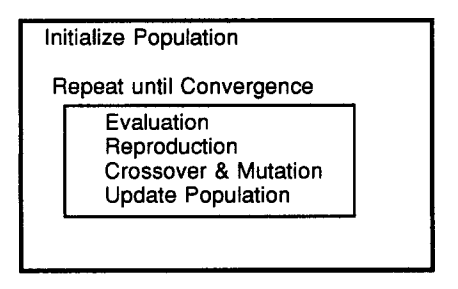

General scheme for genetic algorithm. Source: Gallagher & Sambridge (1994). 

---

**Short description:**

An EA uses mechanisms inspired by biological evolution, such as reproduction, **mutation**, **recombination**, and **survival selection**. Possible solutions to the optimization problem are considered the **individuals** in a **population**, and their quality is determined by a **fitness** function. **Sequential application of the operators drives the evolution of the population.**


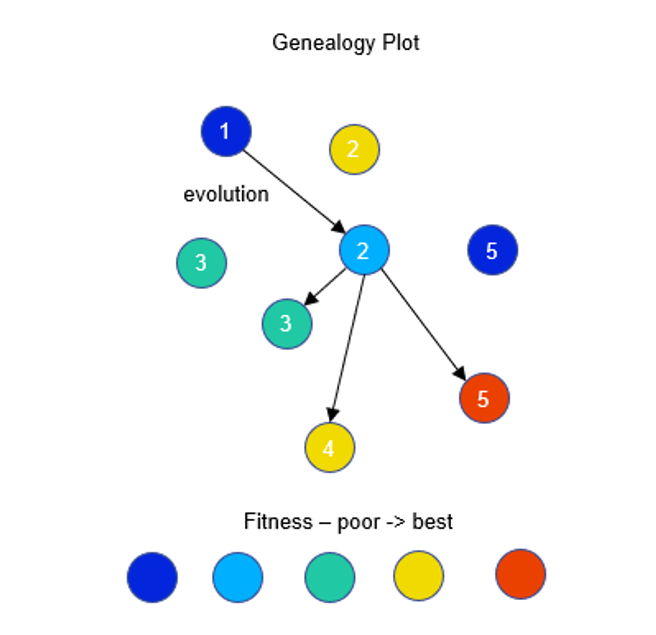

source: https://drek4537l1klr.cloudfront.net/lanham/v-12/Figures/03image009.png


----

Examples in: https://github.com/DEAP/notebooks

----


# Inputs and outputs

### Directory for saving model and other related stuffs: 

In [3]:
data_path = FOLDER_OUTPUT+MODEL_NAME+'/DATA/'

### Directory for saving figures: 

In [4]:
figures_path = FOLDER_OUTPUT+MODEL_NAME+'/FIGURES/'

---------

# Loading the observed data generated previosly in the notebook (generating_observed_data_via_disba.ipynb)

In [5]:
filename_feather = data_path+'observed_data.feather'

obs_data = pd.read_feather(filename_feather)

## Over a slice of the generated 3D block, we created 10 receptors:

In [6]:
obs_data

,receptor,station,density,velocity_s,depth,dispersion_curve,frequency
0,1,1,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[143.39548072405796, 146.8194065053076, 150.61...","[100.0, 98.99999999999999, 98.00000000000001, ..."
1,6,2,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[143.39548072405796, 146.8194065053076, 150.61...","[100.0, 98.99999999999999, 98.00000000000001, ..."
2,11,3,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[143.39548072405796, 146.8194065053076, 150.61...","[100.0, 98.99999999999999, 98.00000000000001, ..."
3,16,4,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[143.39548072405796, 146.8194065053076, 150.61...","[100.0, 98.99999999999999, 98.00000000000001, ..."
4,21,5,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[143.39548072405796, 146.8194065053076, 150.61...","[100.0, 98.99999999999999, 98.00000000000001, ..."
5,26,6,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[143.39548072405796, 146.8194065053076, 150.61...","[100.0, 98.99999999999999, 98.00000000000001, ..."
6,31,7,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[143.39548072405796, 146.8194065053076, 150.61...","[100.0, 98.99999999999999, 98.00000000000001, ..."
7,36,8,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[143.39548072405796, 146.8194065053076, 150.61...","[100.0, 98.99999999999999, 98.00000000000001, ..."
8,41,9,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[206.01745338030108, 207.24850806780094, 208.4...","[100.0, 98.99999999999999, 98.00000000000001, ..."
9,46,10,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.34528135...","[1000.2592585370571, 1000.2592585370571, 1000....","[-2.0, -1.9166666666666667, -1.833333333333333...","[206.01745338030108, 207.24850806780094, 208.4...","[100.0, 98.99999999999999, 98.00000000000001, ..."


# **Inversion Scheme**

Genetic programming is a special field of evolutionary computation that aims at building programs automatically to solve problems independently of their domain. The algorithm does not know the details of the problem it is trying to solve. The problem of deciding how much better a particular model is requires a little more thought. As it progresses, the genetic algorithm is designed to retain the better models preferentially through stochastic sampling processes so that the fitter models are more likely to survive and procreate. In effect, that probability of a given model being sampled and selected for the next stage of the genetic algorithm depends on its fitness value (Gallagher & Sambridge, 1994).

In the inversion, we chose the shear-wave velocities, number and thicknesses of layers as the parameters to be determined, because they significantly affect the dispersion curve. In the
GA, these parameters are encoded in gene type that is suitable for the genetic operations. Variants are possible at most stages of the genetic algorithm, although the basic requirements always include the encoding, evaluation, and operation stages (Gallagher & Sambridge, 1994).

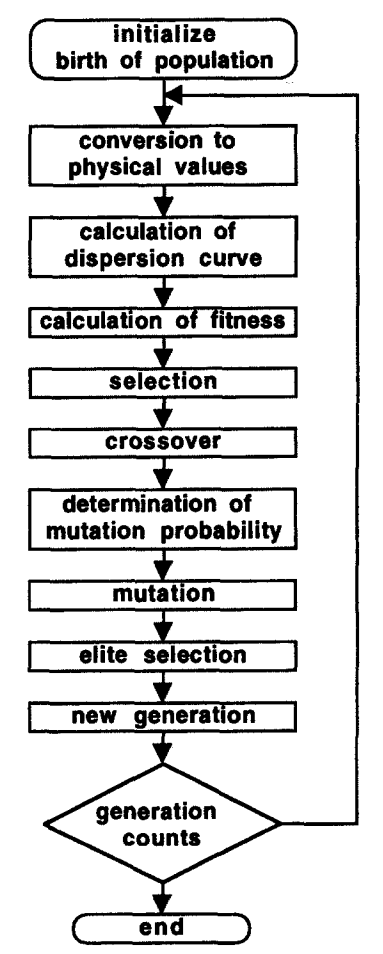

Flowdiagram of the modified GA-based inversion method by Yamanaka and H. Ishida (1996).

## **In the inversion, we searched for an optimal combination of:**
- S-wave velocity,
- Thickness for each layer.


## **Building upon the previous figure, a detailed description of the functions used to generate the genetic algorithm is provided below:**

1. **Initialization**:  Randomly create models for the initial population within a given range of random layer thicknesses and shear-wave velocities.

In [7]:
def create_layers(min_thick_layer, max_thick_layer,max_total=MAX_TOTAL,max_layers=MAX_LAYERS):

    '''
    This function generates a list of random layer thicknesses that sum exactly to a specified total (`max_total`). 
    Each layer thickness is randomly drawn from a uniform distribution between `min_thick_layer` and `max_thick_layer`, 
    ensuring that all layers meet the minimum thickness requirement (`min_thick_layer`). 
    The final layer is adjusted so that the total thickness precisely matches `max_total`.

    Parameters:
    -----------
    min_thick_layer : float
        Minimum thickness of an individual layer (m).
    max_thick_layer : float
        Maximum thickness of an individual layer  (m).
    max_total : float, optional (default=2 meters)
        Maximum total thickness of all layers (m).
    max_layers : float, optional (default=5 layers)
        Number of layers of the model.

    Returns:
    --------
    thick_lst : list of float
        A list of layer thicknesses.

    '''

    values = []
    current_sum = 0.0
    
    while len(values) < max_layers:
        remaining = round(max_total - current_sum, 2)
        
        if remaining <= 0:
            break
        
        possible_values = [v for v in np.arange(min_thick_layer, max_thick_layer+0.01, 0.01) if v <= remaining]
        
        if not possible_values or len(values) == max_layers - 1:
            values.append(remaining)
            break
        
        choice = random.choice(possible_values)
        values.append(round(choice, 2))
        current_sum = round(current_sum + choice, 2)
        
    return values

# ------------------------------------------------------------------

def uniform(low_thick, up_thick,max_total,max_layers,low_vels,up_vels):
    """
    Generates a random velocity model with layer thicknesses (m) and Vs values (m/s).

    This function first creates a set of random layer thicknesses using 
    `create_layers()`, then assigns shear wave velocities (Vs) to each layer 
    based on a uniform distribution.

    Parameters:
    -----------
    low_thick : float
        Lower bound for layer thickness (m).
    up_thick : float
        Upper bound for layer thickness (m).
    low_vels : float
        Lower bound for Vs values (m/s).
    up_vels : float
        Upper bound for Vs values (m/s).
    max_total : float, optional (default=2 meters)
        Maximum total thickness of all layers (m).
    max_layers : float, optional (default=5 layers)
        Number of layers of the model.

    Returns:
    --------
    model : list
        A list containing:
        - `thickness_lst` (list of float): Layer thicknesses.
        - `vs_lst` (list of float): Corresponding Vs values.

    Notes:
    ------
    - The first layer's Vs is sampled uniformly between `low_vels` and `up_vels`.
    - Subsequent layers have Vs values increasing with depth, where the upper 
      and lower bounds for Vs are scaled by the layer index.
    - This function is used in the DEAP framework for generating models:
      
        toolbox.register("model", uniform, lower_thick, upper_thick, lower_vs, upper_vs)
    """
    
    thickness_lst = create_layers(low_thick,up_thick,max_total,max_layers)
    
    vs_lst = []
    for s in range(1,len(thickness_lst)+1):
        if s == 1:
            vs_lst.append(round(np.random.uniform(low_vels,up_vels)))
        else:
            vs_lst.append(round(np.random.uniform(low_vels*(0.75*s),up_vels*(0.5*s))))
    return [thickness_lst,vs_lst]

2. **Evaluation**: After defining a population of models, we create a function to estimate the fitness value (misfit function) for each model;

**Misfit definition:**

Given an individual (random model), the theoretical dispersion curve is computed, and the misfit value is evaluated. 

If the data curves include an uncertainty estimate, the misfit is defined as

$misfit = \sqrt{\sum_{i=1}^{n^f}\frac{(x_{di}-x_{ci})^2}{\sigma_{i}^{2}n_{f}}}$

where:
- $x_{di}$ is the velocity of the data curve at frequency $f_{i}$;
- $x_{ci}$ is the velocity of the calculated curve at frequency $f_{i}$;
- $\sigma_{i}$ is the uncertainty of the frequency samples considered; and
- $n_{f}$ is the number of frequency samples considered;

If no uncertainty is provided, $\sigma_{i}$ is replaced by $x_{di}$ in equation.

In [8]:
def inversion_objective(individual, true_disp,number_samples=100):
    """
    Objective function for inversion using DEAP.

    This function evaluates the misfit between the experimental Rayleigh wave 
    dispersion data and the theoretical dispersion curve simulated from a given 
    shear wave velocity (Vs) profile.

    Parameters:
    -----------
    individual : list or array
        Estimated Vs profile used for optimization.
    true_disp : array
        Experimental Rayleigh wave phase velocity dispersion data.
    number_samples : int, optional (default=100)
        Number of frequency samples considered for misfit calculation.

    Returns:
    --------
    misfit : float
        Misfit value computed as the root mean square error (RMSE) 
        normalized by the standard deviation of the experimental data.
    
    Notes:
    ------
    - The theoretical dispersion curve is obtained by first creating a velocity 
      model from the Vs profile and then estimating the Rayleigh wave phase velocities.
    - The misfit formula is:
    
        misfit = sqrt(sum((xdi - xci)^2 / σi^2) / nf)
        
      where:
        - xdi: Experimental Rayleigh wave phase velocity at frequency fi
        - xci: Theoretical Rayleigh wave phase velocity for the trial model at fi
        - σi: Standard deviation of the experimental data at fi
        - nf: Number of frequency samples
    - If an error occurs, the function returns a high misfit value (10).
    """
    
    try:
        simulated_velocity_model = create_velocity_model_from_profile_vs(individual)
            
        simulated_cpr = estimate_disp_from_velocity_model(simulated_velocity_model)
            
        simulated_dispersion = simulated_cpr.velocity*1000
                
        nf = number_samples 
        sigma = np.std(true_disp)
    
        misfit = np.sqrt(np.sum(((true_disp - simulated_dispersion) ** 2) / (sigma ** 2)) / nf)

   
    except:
        misfit = 10
        
    return misfit,

3. **Statistics**: Compute the mean, standard deviation, minimum, and maximum of the individuals' fitness values to track the optimization progress;

In [9]:
def statistics_save(individual):
    """
    Retrieves the fitness value of an individual.

    This function returns the fitness value(s) of the given individual, 
    which is used for tracking statistics such as mean, standard deviation, 
    minimum, and maximum fitness during the optimization process.

    Parameters:
    -----------
    individual : object
        An individual solution with an assigned fitness value.

    Returns:
    --------
    fitness_value : tuple
        The fitness value(s) of the individual.
    """
    
    return individual.fitness.values

4. **Selection**: Process of choosing individuals from the population to form the next generation. It is based on their fitness, with the goal of selecting individuals that will contribute the best genetic material to future generations

*Tournament selection* chooses individuals for the next generation using tournament selection, where three candidates compete, and the fittest is selected;

5. **Mutation**: Each mutation has its own characteristics and may be applied to different types of individuals;

In [10]:
def mutate_gaussian(ind, mutpb=MUTPB):
    """
    Applies Gaussian mutation to the individual's layer thicknesses and velocities,
    ensuring the structure of each sublist remains unchanged.

    Parameters:
    -----------
    individual : list
        The individual consisting of two sublists: thicknesses and velocities.
    mutpb : float, optional (default=0.1)
        Probability of mutating each value.

    Returns:
    --------
    tuple
        The mutated individual.
    """
    for i in range(len(ind)):  # Iterate over sublists (thicknesses and velocities)
        for j in range(len(ind[i])):  # Iterate over elements in sublist
            if random.random() < mutpb:  # Mutation probability check
                value = ind[i][j]
                sigma = 0.1 * abs(value)  # Standard deviation as 10% of the current value
                ind[i][j] += round(np.random.normal(0, sigma),2)  # Apply Gaussian noise
    return ind,

6. **Crossover**: They only mate individuals, this means that an independent copies must be made prior to mating the individuals if the original individuals have to be kept or are references to other individuals;

In [11]:
def crossover_two_point(ind1, ind2, cxpb=CXPB):
    """
    Applies Two-Point Crossover to individuals while preserving the internal 
    structure of their sublists and respecting the shortest length between them.

    Parameters:
    -----------
    ind1 : list
        The first individual, consisting of two sublists.
    ind2 : list
        The second individual, also consisting of two sublists.
    cxpb : float, optional (default=0.5)
        The probability of performing crossover.

    Returns:
    --------
    tuple
        The two individuals after crossover.
    """
    for i in range(len(ind1)):  # Iterate over sublists (thickness and velocity)
        if random.random() < cxpb:  # Check if crossover occurs for this sublist
            # Determine the shortest length between corresponding sublists
            size = min(len(ind1[i]), len(ind2[i]))
            
            # Select two crossover points
            point1, point2 = sorted(random.sample(range(size), 2))
                
            # Swap values between the two points
            for j in range(point1, point2 + 1):
                ind1[i][j], ind2[i][j] = ind2[i][j], ind1[i][j]
                    
    return ind1, ind2

7. **Hall of fame**: Specific structure which contains the n best individuals.

A special structure in DEAP that stores the n best individuals found during the evolutionary process. 

It preserves top-performing solutions, ensuring they are not lost due to genetic operations like crossover or mutation.

For a more detailed explanation of each step, please refer to https://deap.readthedocs.io/en/master/tutorials/basic/part1.html.

# **DEAP Configuration for Evolutionary Algorithm Setup**

The toolbox is intended to contain all the evolutionary tools, from the object initializers to the evaluation operator.
It allows easy configuration of each algorithm. 

This function configures the DEAP framework for a genetic algorithm, defining the necessary components for evolutionary processes such as initialization, evaluation, crossover, mutation, and selection. The configuration follows these steps:

1. **Fitness and Individual Creation**:  
   It creates a `FitnessMin` class for minimizing the fitness value and a custom `Individual` class that holds a list and is associated with the fitness class.

2. **Toolbox Initialization**:  
   The `Toolbox` object is instantiated to store and manage evolutionary operators. These operators are essential for the algorithm’s processes.

3. **Attribute Generator**:  
   The `model` function, based on a uniform distribution of layer thickness and shear-wave velocities, generates the individual attributes.

4. **Individual and Population Initialization**:  
   The toolbox registers functions to create an individual by applying the `model` generator and to initialize a population from repeated individual generations.

5. **Evaluation Function**:  
   The `evaluate` function computes the misfit value between the theoretical and true dispersion curves, using the `inversion_objective` function.

6. **Crossover Operation**:  
   A two-point crossover operation (`mate`) is registered, allowing the mixing of two individuals to exchange genetic information, ensuring diversity in the population.

7. **Mutation Operation**:  
    The `mutate_gaussian` function applies a mutation by adding Gaussian noise to the values of an individual's attributes (layer thickness and velocity). This introduces small random variations, facilitating the exploration of new solutions while maintaining the structure of the individual.

8. **Selection Strategy**:  
   A tournament selection method is used (`select`), where three individuals are randomly selected, and the one with the best fitness is chosen for reproduction.

In [12]:
def configure_deap(estimated_disp,lower_thick,upper_thick,lower_vs,upper_vs,max_total,max_layers):

    # Fitness and Individual Creation:
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    # Toolbox Initialization:
    toolbox = base.Toolbox()

    # Using Multiple Processors 
    pool = multiprocessing.Pool(processes=NUM_PROCESS)
    toolbox.register("map", pool.map)
    
    # Attribute Generator:
    toolbox.register("model", uniform, lower_thick, upper_thick,max_total,max_layers,lower_vs, upper_vs)

    # Individual and Population Initialization:
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.model)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Evaluation Function:
    toolbox.register("evaluate", inversion_objective, true_disp=estimated_disp)

    # Crossover Operation:
    toolbox.register("mate", crossover_two_point)

    # Mutation Operation:
    toolbox.register("mutate", mutate_gaussian)
    
    # Selection Strategy:
    toolbox.register("select", tools.selTournament, tournsize=10)
    
    return toolbox

---------------------

# **In order to solve our problem**: 

## **Running the Evolutionary Algorithm with DEAP:**

The code provided initializes a population of 1,000 individuals and sets up statistical tracking and a Hall of Fame to monitor the best-performing individuals throughout the evolutionary process. It then runs a simple evolutionary algorithm using DEAP's eaSimple function, with specified probabilities for crossover and mutation, over 30 generations.

In [13]:
dic_inversion = []
start_time = time.time()

# Number of inversions:
n_inv = N_INV

for ivx in tqdm(range(n_inv),total=len(range(n_inv)),desc='Number of inversions', leave=False, dynamic_ncols=True,colour='green'):
    for idx, dat in enumerate(tqdm(obs_data.iterrows(),total=obs_data.shape[0], desc='Station', colour='red',leave=False, dynamic_ncols=True)):
                    
            # Loading the dispersion curves estimated:
            estimated_disp = dat[1]['dispersion_curve']
            
            # Starting DEAP:
            # Parameters (Space search):
            # - Observed dispersion curve
            # - Layers minimum thickness
            # - Layers maximum thickness
            # - First layer minumum velocity
            # - First layer maximum velocity
            # - Maximum thickness
            toolbox = configure_deap(estimated_disp, MIN_THICK_LAYER, MAX_THICK_LAYER, LOW_VELS, UP_VELS,MAX_TOTAL,MAX_LAYERS)
                    
            # Starting population:
            population = toolbox.population(n=POPULATION)

            # Starting statistical measurement:
            estatistica = tools.Statistics(statistics_save)
            estatistica.register('mean', np.mean)
            estatistica.register('min', np.min)
            estatistica.register('max', np.max)

            # Starting best solution estimation:
            hof = tools.HallOfFame(HOF_NUM)
    
            # Starting the algorithm
            result, log = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,stats=estatistica, halloffame=hof, verbose=False)
            
            # -----------------------------------------------------------------------------------
            # Saving inversion results 
        
            dic_results = {'Vs': [i[1] for i in hof],'thick': [i[0] for i in hof],'misfit': [i['mean'] for i in log],'ngen': [i['gen'] for i in log],'misfit_min':[i['mean'] for i in log],'station':idx+1,'receptor':obs_data['receptor'][idx],'inversion':ivx+1}
            dic_inversion.append(dic_results)
                
# -----------------------------------------------------------------------------------
# End
end_time = time.time()
elapsed_time = end_time - start_time
print('Time spent (m):', elapsed_time / 60)

Station:  30%|██████████▌                        | 3/10 [01:50<04:19, 37.02s/it]
                                                                                Process ForkPoolWorker-45:
Process ForkPoolWorker-48:
Process ForkPoolWorker-47:
Process ForkPoolWorker-42:
Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-46:
Process ForkPoolWorker-43:
Process ForkPoolWorker-41:
Process ForkPoolWorker-39:
Process ForkPoolWorker-44:

KeyboardInterrupt

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sysop/Programs/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/sysop/Programs/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last)

## **Saving the results:**

In [ ]:
df_inversion = pd.DataFrame.from_dict(dic_inversion)

In [ ]:
df_inversion.to_feather(data_path+'inversion.feather')

In [ ]:
df_inversion

# **Final Results:**

In [ ]:
df_inversion = pd.read_feather(data_path+'inversion.feather')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# cria um colormap (10 cores, normalizando de 1 a 10)
norm = plt.Normalize(vmin=df_inversion['station'].values.min(), vmax=df_inversion['station'].values.max())
# Norm para associar cada estação a uma cor
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(df_inversion['station'].values.min()-0.5, 
                                                    df_inversion['station'].values.max()+1.5, 1),
                                                    ncolors=len(df_inversion['station'].values))
# forma moderna de pegar colormap
cmap = plt.get_cmap('magma', len(df_inversion['station'].values))  # ainda funciona para cores discretas

for dativ in df_inversion.iterrows():
    color = cmap(norm(dativ[1]['station']))
    ax.semilogy(dativ[1]['ngen'], dativ[1]['misfit'], '-',color=color)
        
ax.set_xlabel('Number of generations')
ax.set_ylabel('Misfit value')
ax.axvline(x=len(dativ[1]['ngen'])-1, color='red', linestyle='--', label='Last gen')
ax.legend(loc='upper right')
ax.grid(True, which='both')
plt.tight_layout()
ax.tick_params(axis='both', which='both', direction='in', 
               top=True, bottom=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True,
               labelright=True)
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_title('Misfit evolution')

# ScalarMappable para a colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Colorbar discreta
cbar = plt.colorbar(sm, ax=ax, ticks=df_inversion['station'].values)
cbar.set_label("Station")
      
fig.savefig(figures_path+'misfit_total_.png', dpi=300)